# Sleep stage classification: Random Forest & Hidden Markov Model
____

This model aims to classify sleep stages based on two EEG channel. We will use the features extracted in the `pipeline.ipynb` notebook as the input to a Random Forest. The output of this model will then be used as the input of a HMM. We will implement our HMM the same as in this paper (Malafeev et al., « Automatic Human Sleep Stage Scoring Using Deep Neural Networks »).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Ensure parent folder is in PYTHONPATH
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline

from itertools import groupby

import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     GroupKFold,
                                     cross_validate)
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report,
                             f1_score,
                             cohen_kappa_score,
                             make_scorer)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from scipy.signal import medfilt

from hmmlearn.hmm import MultinomialHMM
from constants import (SLEEP_STAGES_VALUES,
                       N_STAGES,
                       EPOCH_DURATION)
from model_utils import (print_hypnogram,
                         train_test_split_one_subject,
                         train_test_split_according_to_age)

## Load the features
___

In [3]:
# position of the subject information and night information in the X matrix
SUBJECT_IDX = 0 
NIGHT_IDX = 1
USE_CONTINUOUS_AGE = False
DOWNSIZE_SET = False
TEST_SET_SUBJECTS = [0.0, 24.0, 49.0, 71.0]

if USE_CONTINUOUS_AGE:
    X_file_name = "../data/x_features-age-continuous.npy"
    y_file_name = "../data/y_observations-age-continuous.npy"
else:
    X_file_name = "../data/x_features.npy"
    y_file_name = "../data/y_observations.npy"

In [4]:
X_init = np.load(X_file_name, allow_pickle=True)
y_init = np.load(y_file_name, allow_pickle=True)


In [5]:
X_init = np.vstack(X_init)
y_init = np.hstack(y_init)
print(X_init.shape)
print(y_init.shape)


(168954, 50)
(168954,)


In [6]:
print("Number of subjects: ", np.unique(X_init[:,SUBJECT_IDX]).shape[0]) # Some subject indexes are skipped, thus total number is below 83 (as we can see in https://physionet.org/content/sleep-edfx/1.0.0/)
print("Number of nights: ", len(np.unique([f"{int(x[0])}-{int(x[1])}" for x in X_init[:,SUBJECT_IDX:NIGHT_IDX+1]])))


Number of subjects:  78
Number of nights:  153


## Downsizing sets
___

We will use the same set for all experiments. It includes the first 20 subjects, and excludes the 13th, because it only has one night.

The last subject will be put in the test set. 

In [7]:
if DOWNSIZE_SET:
    # Filtering to only keep first 20 subjects
    X_20 = X_init[np.isin(X_init[:,SUBJECT_IDX], range(20))]
    y_20 = y_init[np.isin(X_init[:,SUBJECT_IDX], range(20))]

    # Exclude the subject with only one night recording (13th)
    MISSING_NIGHT_SUBJECT = 13

    X = X_20[X_20[:,SUBJECT_IDX] != MISSING_NIGHT_SUBJECT]
    y = y_20[X_20[:,SUBJECT_IDX] != MISSING_NIGHT_SUBJECT]

    print(X.shape)
    print(y.shape)
else:
    X = X_init
    y = y_init

In [8]:
print("Number of subjects: ", np.unique(X[:,SUBJECT_IDX]).shape[0]) # Some subject indexes are skipped, thus total number is below 83 (as we can see in https://physionet.org/content/sleep-edfx/1.0.0/)
print("Subjects available: ", np.unique(X[:,SUBJECT_IDX]))
print("Number of nights: ", len(np.unique([f"{int(x[0])}-{int(x[1])}" for x in X[:,SUBJECT_IDX:NIGHT_IDX+1]])))

Number of subjects:  78
Subjects available:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 70. 71. 72. 73. 74.
 75. 76. 77. 80. 81. 82.]
Number of nights:  153


## Train, validation and test sets
___

If we downsize the dataset, the test set will only contain the two nights recording of the last subject (no 19) will be the test set. The rest will be the train and validation sets.

If we did not downsize the dataset, we will randomly pick a subject from each age group to be in the test set. Both nights (if there are two) are placed in the test set so that the classifier does not train on any recordings from a subject placed in the test set.


In [9]:
if DOWNSIZE_SET:
    X_test, X_train_valid, y_test, y_train_valid = train_test_split_one_subject(X, y)
else:
    X_test, X_train_valid, y_test, y_train_valid = train_test_split_according_to_age(X,
                                                                                     y,
                                                                                     subjects_test=TEST_SET_SUBJECTS,
                                                                                     use_continuous_age=USE_CONTINUOUS_AGE)
    
print(X_test.shape, X_train_valid.shape, y_test.shape, y_train_valid.shape)

Selected subjects for the test set are:  [0.0, 24.0, 49.0, 71.0]
(8123, 50) (160831, 50) (8123,) (160831,)


## Random forest validation
___

In [10]:
NB_KFOLDS = 5
NB_CATEGORICAL_FEATURES = 2
NB_FEATURES = 48

CLASSIFIER_PIPELINE_KEY = 'classifier'

def get_random_forest_model():
    return Pipeline([
        ('scaling', ColumnTransformer([
            ('pass-through-categorical', 'passthrough', list(range(NB_CATEGORICAL_FEATURES))),
            ('scaling-continuous', StandardScaler(copy=False), list(range(NB_CATEGORICAL_FEATURES,NB_FEATURES)))
        ])),
        (CLASSIFIER_PIPELINE_KEY, RandomForestClassifier(
            n_estimators=100,
            random_state=42, # enables deterministic behaviour
            n_jobs=-1
        ))
    ])

For the cross validation, we will use the `GroupKFold` technique. For each fold, we make sure to train and validate on different subjects, to avoid overfitting over subjects.

In [11]:
%%time

accuracies = []
macro_f1_scores = []
weighted_f1_scores = []
kappa_agreements = []
emission_matrix = np.zeros((N_STAGES,N_STAGES))

for train_index, valid_index in GroupKFold(n_splits=5).split(X_train_valid, groups=X_train_valid[:,SUBJECT_IDX]):
    # We drop the subject and night indexes
    X_train, X_valid = X_train_valid[train_index, 2:], X_train_valid[valid_index, 2:]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]
    
    # Scaling features and model training
    training_pipeline = get_random_forest_model()
    training_pipeline.fit(X_train, y_train)
    
    # Validation
    y_valid_pred = training_pipeline.predict(X_valid)

    print("----------------------------- FOLD RESULTS --------------------------------------\n")
    current_kappa = cohen_kappa_score(y_valid, y_valid_pred)

    print("TRAIN:", train_index, "VALID:", valid_index, "\n\n")
    print(confusion_matrix(y_valid, y_valid_pred), "\n")
    print(classification_report(y_valid, y_valid_pred, target_names=SLEEP_STAGES_VALUES.keys()), "\n")
    print("Agreement score (Cohen Kappa): ", current_kappa, "\n")
    
    accuracies.append(round(accuracy_score(y_valid, y_valid_pred),2))
    macro_f1_scores.append(f1_score(y_valid, y_valid_pred, average="macro"))
    weighted_f1_scores.append(f1_score(y_valid, y_valid_pred, average="weighted"))
    kappa_agreements.append(current_kappa)
    
    for y_pred, y_true in zip(y_valid_pred, y_valid):
        emission_matrix[y_true, y_pred] += 1

emission_matrix = emission_matrix / emission_matrix.sum(axis=1, keepdims=True)

----------------------------- FOLD RESULTS --------------------------------------

TRAIN: [  2137   2138   2139 ... 158843 158844 158845] VALID: [     0      1      2 ... 160828 160829 160830] 


[[ 7196   209   108     3   136]
 [ 1280   552  1360     1   524]
 [ 1063   486 10613   330   446]
 [  153     8   651  2114     5]
 [  885   963  1242     5  2471]] 

              precision    recall  f1-score   support

           W       0.68      0.94      0.79      7652
          N1       0.25      0.15      0.19      3717
          N2       0.76      0.82      0.79     12938
          N3       0.86      0.72      0.79      2931
         REM       0.69      0.44      0.54      5566

    accuracy                           0.70     32804
   macro avg       0.65      0.61      0.62     32804
weighted avg       0.68      0.70      0.68     32804
 

Agreement score (Cohen Kappa):  0.5848757711197277 

----------------------------- FOLD RESULTS --------------------------------------

TRAIN: [ 

In [12]:
print(f"Mean accuracy          : {np.mean(accuracies):0.2f} ± {np.std(accuracies):0.3f}")
print(f"Mean macro F1-score    : {np.mean(macro_f1_scores):0.2f} ± {np.std(macro_f1_scores):0.3f}")
print(f"Mean weighted F1-score : {np.mean(weighted_f1_scores):0.2f} ± {np.std(weighted_f1_scores):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(kappa_agreements):0.2f} ± {np.std(kappa_agreements):0.3f}")

Mean accuracy          : 0.72 ± 0.033
Mean macro F1-score    : 0.65 ± 0.028
Mean weighted F1-score : 0.71 ± 0.030
Mean Kappa's agreement : 0.62 ± 0.043


## Validation results
___

### Dimension reduction
___

*Definitions from scikit learn*:

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

We will compare each method and keep the one with the best results.

#### 1. Linear discriminant analysis
___

LDA only allows `n_components` between 1 and `min(n_classes - 1, n_features)`. We will then **reduce our 48 features to 4 components**.

A particularity of LDA is that it has pratically no hyperparameters to fix (except the number of components, which is limited).

In [13]:
def get_random_forest_model_with_dim_reduction(dimension_reducer):
    return Pipeline([
        ('scaling', ColumnTransformer([
            ('pass-through-categorical', 'passthrough', list(range(NB_CATEGORICAL_FEATURES))),
            ('scaling-continuous', StandardScaler(copy=False), list(range(NB_CATEGORICAL_FEATURES,NB_FEATURES)))
        ])),
        ('dimension_reduction', dimension_reducer),
        (CLASSIFIER_PIPELINE_KEY, RandomForestClassifier(
            n_estimators=100,
            random_state=42, # enables deterministic behaviour
            n_jobs=-1
        ))
    ])


def get_cv_iterator(n_splits=2):
    return GroupKFold(n_splits=n_splits).split(
        X_train_valid, groups=X_train_valid[:,SUBJECT_IDX]
    )

clf = get_random_forest_model_with_dim_reduction(LinearDiscriminantAnalysis())

In [14]:
scores = cross_validate(
    estimator=clf,
    X=X_train_valid,
    y=y_train_valid,
    groups=X_train_valid[:,SUBJECT_IDX],
    scoring={
        "agreement": make_scorer(cohen_kappa_score),
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
    cv=get_cv_iterator(n_splits=5),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.2s finished


In [15]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(scores['test_agreement']):0.2f} ± {np.std(scores['test_agreement']):0.3f}")

Mean accuracy          : 0.68 ± 0.032
Mean macro F1-score    : 0.60 ± 0.026
Mean weighted F1-score : 0.67 ± 0.030
Mean Kappa's agreement : 0.56 ± 0.044


#### 2. Principal component analysis
___

It is a non supervised dimension reduction method. In that sense, it can lead to worst results than LDA. On the other side, we can set the `n_components` to any value between 1 and `n_features`, which allows us to control the information that we leave out.

In [16]:
clf = get_random_forest_model_with_dim_reduction(PCA())
clf.fit(X_train_valid,y_train_valid)
np.sum(clf[1].explained_variance_ratio_)

1.0000000000000002

In [17]:
for number_of_components_included in [1,2,4,10,16,20,30]:
    ratio_explained = np.sum(clf[1].explained_variance_ratio_[:number_of_components_included])
    print(f"{number_of_components_included} components included: {ratio_explained:.4f}")

1 components included: 0.9253
2 components included: 0.9405
4 components included: 0.9591
10 components included: 0.9807
16 components included: 0.9906
20 components included: 0.9943
30 components included: 0.9987


Results:
```
1 components included: 0.9253
2 components included: 0.9405
4 components included: 0.9591
10 components included: 0.9807
16 components included: 0.9906
20 components included: 0.9943
30 components included: 0.9987
```

We can try for 4 components (to compare with LDA), 16 components, which corresponds to a reasonable ratio explained (>99%), and 30, which corresponds of almost all of the explained ratio.

In [18]:
def get_score_with_pca(n_components):
    return cross_validate(
        estimator=get_random_forest_model_with_dim_reduction(PCA(n_components=n_components)),
        X=X_train_valid,
        y=y_train_valid,
        groups=X_train_valid[:,SUBJECT_IDX],
        scoring={
            "agreement": make_scorer(cohen_kappa_score),
            "accuracy": 'accuracy',
            "f1-score-macro": 'f1_macro',
            "f1-score-weighted": 'f1_weighted',
        },
        cv=get_cv_iterator(n_splits=5),
        return_train_score=True,
        verbose=1,
        n_jobs=-1
    )

In [19]:
scores = get_score_with_pca(n_components=4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.2s finished


In [20]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(scores['test_agreement']):0.2f} ± {np.std(scores['test_agreement']):0.3f}")

Mean accuracy          : 0.54 ± 0.020
Mean macro F1-score    : 0.48 ± 0.009
Mean weighted F1-score : 0.53 ± 0.016
Mean Kappa's agreement : 0.36 ± 0.026


In [21]:
scores = get_score_with_pca(n_components=16)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [22]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(scores['test_agreement']):0.2f} ± {np.std(scores['test_agreement']):0.3f}")

Mean accuracy          : 0.69 ± 0.032
Mean macro F1-score    : 0.61 ± 0.034
Mean weighted F1-score : 0.67 ± 0.034
Mean Kappa's agreement : 0.57 ± 0.044


In [23]:
scores = get_score_with_pca(n_components=30)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [24]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(scores['test_agreement']):0.2f} ± {np.std(scores['test_agreement']):0.3f}")

Mean accuracy          : 0.70 ± 0.027
Mean macro F1-score    : 0.61 ± 0.031
Mean weighted F1-score : 0.68 ± 0.030
Mean Kappa's agreement : 0.58 ± 0.040


In [25]:
scores = get_score_with_pca(n_components=40)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [26]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")
print(f"Mean Kappa's agreement : {np.mean(scores['test_agreement']):0.2f} ± {np.std(scores['test_agreement']):0.3f}")

Mean accuracy          : 0.71 ± 0.028
Mean macro F1-score    : 0.62 ± 0.031
Mean weighted F1-score : 0.68 ± 0.030
Mean Kappa's agreement : 0.59 ± 0.040


If we resume all our results, which we tested upon 5 folds, we have the following:

|  Score             |  without      | LDA           | PCA (n_comp=4) | PCA (n_comp=16) | PCA (n_comp=30) | PCA (n_comp=40) |
|--------------------|---------------|---------------|----------------|-----------------|-----------------|-----------------|
| accuracy           | 0.72 ± 0.030  | 0.68 ± 0.032  | 0.54 ± 0.020   |  0.69 ± 0.031   |  0.70 ± 0.026   |  0.71 ± 0.027   |
|  macro F1-score    | 0.65 ± 0.027  |  0.60 ± 0.026 | 0.48 ± 0.008   |  0.61 ± 0.032   |  0.61 ± 0.029   |  0.62 ± 0.030   |
|  weighted F1-score | 0.71 ± 0.029  |  0.67 ± 0.029 | 0.53 ± 0.015   |  0.67 ± 0.032   |  0.68 ± 0.029   |  0.68 ± 0.029   |
|  Kappa's agreement | 0.61 ± 0.043  |  0.56 ± 0.043 | 0.36 ± 0.024   |  0.57 ± 0.042   |  0.58 ± 0.038   |  0.59 ± 0.038   |

Considering that:
- the number of features currently defined, namely 48, does not considerably slows down our prediction (about 228 ms)
- the scores obtained with LDA and PCA are significally lower than without applying dimension reduction
- we prefer to have a slower model to train (currently trainable under about 2 minutes) than to lose some accuracy
- our current classifier still works when there is multicolinearity between features (PCA and LDA should have otherwise been used)

We will not apply dimension reduction on this model.

### Random forest hyperparameters
___

We have fixed the same hyperparameters for the other categories:
- `StandardScaler` for all continuous features
- Training on all the dataset (83 subjects)
- Test set contains the following subjects: `[0.0, 24.0, 49.0, 71.0]`
- No postprocessing step
- RF with its default hyperparameters

In [27]:
def print_hyperparam_tuning_results(search_cv_results):

    for idx, rank in enumerate(search_cv_results['rank_test_score']):
        current_param = search_cv_results['params'][idx]
        score_mean = search_cv_results['mean_test_score'][idx]
        score_uncertainty = search_cv_results['std_test_score'][idx]
        print(f"{rank}. Parameter {current_param} has a score of {score_mean:0.4f} ± {score_uncertainty:0.3f}")
        
def evaluate_hyperparams_grid(grid_param):
    search = GridSearchCV(
        estimator=get_random_forest_model(),
        param_grid=grid_param,
        scoring=make_scorer(cohen_kappa_score),
        cv=get_cv_iterator(),
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train_valid[:,2:], y_train_valid)

    print_hyperparam_tuning_results(search.cv_results_)
    
def evaluate_hyperparams_randomized(params):
    search = RandomizedSearchCV(
        estimator=get_random_forest_model(),
        param_distributions=params,
        scoring=make_scorer(cohen_kappa_score),
        cv=get_cv_iterator(),
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train_valid[:,2:], y_train_valid)

    print_hyperparam_tuning_results(search.cv_results_)

#### 1. class_weight: balanced vs none
___

Weights associated with classes.

Because our dataset has unbalanced data (more N2, less N3 per example), we want to check if it gives better result to have a balanced vs not balanced training set.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))` (Source: sklearn)

In [28]:
%%time

evaluate_hyperparams_grid({
    f"{CLASSIFIER_PIPELINE_KEY}__class_weight": [None, "balanced"]
})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   49.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   49.1s finished


1. Parameter {'classifier__class_weight': None} has a score of 0.6160 ± 0.004
2. Parameter {'classifier__class_weight': 'balanced'} has a score of 0.6106 ± 0.003
CPU times: user 3min 33s, sys: 463 ms, total: 3min 33s
Wall time: 1min 17s



|  Value      |  Score          |
|-------------|-----------------|
| `None`      | 0.6153 ± 0.003  |
|  `balanced` |  0.6114 ± 0.002 |

The chosen value for `class_weight` is then `None`.

#### 2. n_estimators
___

Definition: the number of trees in the forest.

It's usually better to pick a higher n_estimators, but it takes slower to train and predict.

In [ ]:
%%time

evaluate_hyperparams_randomized({
    f"{CLASSIFIER_PIPELINE_KEY}__n_estimators": np.linspace(50, 1000, 8, dtype="int")
})

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/home/william/Documents/PolyDossier/PolyCortex/polydodo/classification/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:277: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


**First experience**: `np.linspace(50, 1000, 8, dtype="int")`

|Rank|  n_estimators |  Score          |
|----|---------------|-----------------|
|1   | 592           |  0.6201 ± 0.005 |
|2   |  728          |  0.6200 ± 0.006 |
|3   |  864          |  0.6200 ± 0.005 |
|4   |  1000         |  0.6193 ± 0.005 |
|5   |  457          |  0.6191 ± 0.006 |
|6   |  321          |  0.6188 ± 0.005 |
|7   |  185          |  0.6177 ± 0.004 |
|8   |  50           |  0.6091 ± 0.004 |

Total running time: 57min 4s

We can see that the range with the best scores is inbetween 457 and 728 (with 592 in the middle).

#### 3. max_features
___

Definition: The number of features to consider when looking for the best split.

By default (`auto` or `sqrt`), the number of features considered is `sqrt(nb_features)`. In our case, it corresponds to `sqrt(48) = 6 features`. We can also define a percentage of features to consider (by passing a `float`), a number (by passing an `int`), or look at all of them (by passing `None`).

As with `n_estimators`, it is better to have a higher `max_features`, but it slows down training and prediction.

In [ ]:
%%time

evaluate_hyperparams_randomized({
    f"{CLASSIFIER_PIPELINE_KEY}__max_features": [4, 5, 6, 7]
})

**First experience**: `["auto", 10, 20, 40, None]`

|Rank|  max_features |  Test score     |
|----|---------------|-----------------|
|1   | 'auto' = 6    |  0.6153 ± 0.003 |
|2   |  10           |  0.6144 ± 0.004 |
|3   |  20           |  0.6136 ± 0.005 |
|4   |  40           |  0.6073 ± 0.000 |
|5   |  None = 48    |  0.6049 ± 0.002 |

Total running time: 21min 36s

We can see that the test score is better when max_features is lower, because we can assume that we overfit our training set.

**Second experience**: `[4, 5, 6, 7]`

|Rank|  max_features |  Test score     |
|----|---------------|-----------------|
|1   | 7             |  0.6153 ± 0.003 |
|2   | 'auto' = 6    |  0.6153 ± 0.003 |
|3   |  5            |  0.6145 ± 0.005 |
|4   |  4            |  0.6142 ± 0.004 |

Total running time: 5min 27s 


#### 4. max_depth
___

Definition of **max_depth**: Maximum depth of every trees in the forest (default=`None`)

If max_depth is `None`, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

The maximum depth should not be too big, there would otherwise be overfitting on the training set. 

In [ ]:
%%time

evaluate_hyperparams_randomized({
    f"{CLASSIFIER_PIPELINE_KEY}__max_depth": [*np.linspace(20, 40, 6, dtype="int"), None]
})

**First experience**: `[*np.linspace(8, 40, 6, dtype="int"), None]`

|Rank|  max_depth    |  Test score     |
|----|---------------|-----------------|
|1   | 33            |  0.6164 ± 0.004 |
|2   |  40           |  0.6160 ± 0.003 |
|3   |  20           |  0.6160 ± 0.005 |
|4   |  27           |  0.6155 ± 0.003 |
|5   |  None         |  0.6153 ± 0.003 |
|6   |  14           |  0.6134 ± 0.005 |
|7   |  8            |  0.5944 ± 0.009 |


Total running time: 8min 47s

We can see that the range with the best scores is in between 20 and 40.

**Second experience**: `[*np.linspace(20, 40, 6, dtype="int"), None]` 

|Rank|  max_depth    |  Test score     |
|----|---------------|-----------------|
|1   | 24            |  0.6177 ± 0.004 |
|2   |  36           |  0.6167 ± 0.004 |
|3   |  32           |  0.6162 ± 0.004 |
|4   |  40           |  0.6160 ± 0.003 |
|5   |  20           |  0.6160 ± 0.005 |
|6   | None          |  0.6153 ± 0.003 |
|7   |  28           |  0.6151 ± 0.003 |

Total running time: 9min 38s


#### 5. min_samples_split and min_samples_leaf
___

Definition of **min_samples_split**: Minimum number of samples required to split an **internal node** (default=2)

Definitionof **min_samples_leaf**: Minimum number of samples required to be at a **leaf node** (default=1). A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

The same reasoning can be applied to min_samples_split, where it shouldn't be too small.

In [ ]:
%%time

evaluate_hyperparams_randomized({
    f"{CLASSIFIER_PIPELINE_KEY}__min_samples_split": [2, 5, 10],
    f"{CLASSIFIER_PIPELINE_KEY}__min_samples_leaf": [1, 2]
})

**First experience**: `min_samples_split": [2, 5, 10], min_samples_leaf": [1, 2]`

|Rank|  min_samples_split    | min_samples_leaf | Test score     |
|----|-----------------------|------------------|----------------|
|1   | 10                    |    1             | 0.6171 ± 0.005 |
|2   |  10                   |      2           | 0.6169 ± 0.006 |
|3   |  2                    |         2        | 0.6167 ± 0.005 |
|4   |  5                    |    1             | 0.6160 ± 0.005 |
|5   |  5                    |     2            | 0.6160 ± 0.005 |
|6   |  2                    |      1           | 0.6153 ± 0.003 |


Total running time: 10min 1s

#### 6. Combining all best parameters to find the best combinaison
____

In [ ]:
%%time

evaluate_hyperparams_randomized({
    f"{CLASSIFIER_PIPELINE_KEY}__n_estimators": [592],
    f"{CLASSIFIER_PIPELINE_KEY}__max_depth": [24, 36],
})

**First experiment**

|Rank|  n_estimators         | max_depth        | min_samples_leaf | Test score     |
|----|-----------------------|------------------|------------------|----------------|
|1   | 550                   |    24            |    2             | 0.6198 ± 0.006 |
|2   | 600                   |    24            |      2           | 0.6198 ± 0.006 |
|3   | 550                   |    36            |         2        | 0.6195 ± 0.006 |
|4   | 450                   |    36            |    1             | 0.6195 ± 0.006 |
|5   | 450                   |    24            |     2            | 0.6195 ± 0.006 |
|6   | 500                   |    36            |      2           | 0.6190 ± 0.006 |
|7   | 600                   |    24            |      1           | 0.6190 ± 0.006 |
|8   | 450                   |    36            |      2           | 0.6190 ± 0.006 |
|9   | 450                   |    24            |      1           | 0.6188 ± 0.006 |
|10  | 550                   |    24            |      1           | 0.6186 ± 0.006 |

Constants hyperparameters:
    class_weight: None,
    max_features: 7,
    min_samples_split: 10

Total running time: 1h 17min 59s

We can see that the best combination has a test score lower than the the configuration of 592 estimators and the default configuration for the other hyperparameters.

**Second experiment**: n_estimators: 592, max_depth: [24, 36]

|Rank| max_depth        | Test score     |
|----|------------------|----------------|
|1   |    24            | 0.6203 ± 0.006 |
|2   |    36            | 0.6201 ± 0.006 |

We have the best, up to date, test score with n_estimators: 592, max_depth: 24, and other hyperparameters set to their default value.

## Random forest training and testing
___

In [27]:
%%time

testing_pipeline = Pipeline([
    ('scaling', ColumnTransformer([
        ('pass-through-categorical', 'passthrough', list(range(NB_CATEGORICAL_FEATURES))),
        ('scaling-continuous', StandardScaler(copy=False), list(range(NB_CATEGORICAL_FEATURES,NB_FEATURES)))
    ])),
    (CLASSIFIER_PIPELINE_KEY, RandomForestClassifier(
        n_estimators=592,
        max_depth=24,
        random_state=42, # enables deterministic behaviour
        n_jobs=-1
    ))
])

testing_pipeline.fit(X_train_valid[:, 2:], y_train_valid);

CPU times: user 21min 12s, sys: 1.87 s, total: 21min 14s
Wall time: 2min 44s


Pipeline(memory=None,
         steps=[('scaling',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pass-through-categorical',
                                                  'passthrough', [0, 1]),
                                                 ('scaling-continuous',
                                                  StandardScaler(copy=False,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28,

In [28]:
feature_importance_indexes = [
    (idx, round(importance,4))
    for idx, importance in enumerate(testing_pipeline.steps[1][1].feature_importances_)
]
feature_importance_indexes.sort(reverse=True, key=lambda x: x[1])

category_feature_range = np.array([2, 3]) - 2
time_domaine_feature_range = np.array([4, 5, 6, 7, 8, 9, 10, 27, 28, 29, 30, 31, 32, 33]) - 2
freq_domain_feature_range = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]) - 2
subband_domain_feature_range = np.array([22, 23, 24, 25, 26, 45, 46, 47, 48, 49]) - 2
fpz_cz_feature_range = np.array(range(2, 25))
pz_oz_feature_range = np.array(range(25, 48))

def get_feature_range_importance(indexes):
    return np.sum([feature[1] for feature in feature_importance_indexes if feature[0] in indexes])

print(f"Categorical features:         {category_feature_range}")
print(f"Time domain features:         {time_domaine_feature_range}")
print(f"Frequency domain features:    {freq_domain_feature_range}")
print(f"Subband time domain features: {subband_domain_feature_range}\n")

print(f"Top 5 features:    {[feature for feature in feature_importance_indexes[:5]]}")
print(f"Bottom 5 features: {[feature for feature in feature_importance_indexes[-5:]]}\n")

print(f"Fpz-Cz feature importances:   {get_feature_range_importance(fpz_cz_feature_range):.4f}")
print(f"Pz-Oz feature importances:    {get_feature_range_importance(pz_oz_feature_range):.4f}\n")

print(f"Category feature importances:            {get_feature_range_importance([0,1]):.4f}")
print(f"Time domain feature importances:         {get_feature_range_importance(time_domaine_feature_range):.4f}")
print(f"Frequency domain feature importances:    {get_feature_range_importance(freq_domain_feature_range):.4f}")
print(f"Subband time domain feature importances: {get_feature_range_importance(subband_domain_feature_range):.4f}")

Categorical features:         [0 1]
Time domain features:         [ 2  3  4  5  6  7  8 25 26 27 28 29 30 31]
Frequency domain features:    [ 9 10 11 12 13 14 15 16 17 18 19 32 33 34 35 36 37 38 39 40 41 42]
Subband time domain features: [20 21 22 23 24 43 44 45 46 47]

Top 5 features:    [(41, 0.0655), (29, 0.0419), (18, 0.0406), (20, 0.0395), (47, 0.0387)]
Bottom 5 features: [(11, 0.0107), (27, 0.0093), (4, 0.0091), (42, 0.0065), (0, 0.0031)]

Fpz-Cz feature importances:   0.4554
Pz-Oz feature importances:    0.5289

Category feature importances:            0.0157
Time domain feature importances:         0.2774
Frequency domain feature importances:    0.4819
Subband time domain feature importances: 0.2250


In [29]:
y_test_pred = testing_pipeline.predict(X_test[:,2:])

print(confusion_matrix(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test, y_test_pred))

[[1518   50    6    3   47]
 [ 210  158  338    0  277]
 [  43   50 3204  197  109]
 [   5    0   30  576    0]
 [  51   77  275    1  898]]
              precision    recall  f1-score   support

           W       0.83      0.93      0.88      1624
          N1       0.47      0.16      0.24       983
          N2       0.83      0.89      0.86      3603
          N3       0.74      0.94      0.83       611
         REM       0.67      0.69      0.68      1302

    accuracy                           0.78      8123
   macro avg       0.71      0.72      0.70      8123
weighted avg       0.76      0.78      0.76      8123

Agreement score (Cohen Kappa):  0.6916179786778069


### Test results
___

#### a) Without tuning
___

Hyperparameters configuration: `(n_estimators=100, others=default)`


#### b) With tuning (v1)
___

Hyperparameters configuration: `(n_estimators=592, others=default)`


#### b) With tuning (v2)
___

Hyperparameters configuration: `(n_estimators=592, max_depth=24, others=default)`

```
              precision    recall  f1-score   support

           W       0.83      0.94      0.88      1624
          N1       0.47      0.15      0.23       983
          N2       0.83      0.89      0.86      3603
          N3       0.75      0.94      0.83       611
         REM       0.67      0.69      0.68      1302

    accuracy                           0.78      8123
   macro avg       0.71      0.72      0.70      8123
weighted avg       0.76      0.78      0.76      8123

Agreement score (Cohen Kappa):  0.692749333654937
```

## Hidden Model Markov
___

In [30]:
def compute_hmm_matrices(y, subject_night):
    transition_matrix = np.zeros((N_STAGES,N_STAGES))
    start_matrix = np.zeros((N_STAGES))

    for night in groupby(zip(y, subject_night), key=lambda x: f"subject{int(x[1][0])}-night{int(x[1][1])}"):
        print(f"Computing file: {night[0]}")
        current_y = np.array([x[0] for x in night[1]])
        start_matrix[current_y[0]] += 1

        for transition in zip(current_y[:-1], current_y[1:]):
            transition_matrix[transition[0], transition[1]] += 1
            
    transition_matrix = transition_matrix/transition_matrix.sum(axis=1, keepdims=True)
    start_matrix = start_matrix/start_matrix.sum()
    
    return transition_matrix, start_matrix
    
transition_matrix, start_matrix = compute_hmm_matrices(y_train_valid, X_train_valid[:,0:2])

Computing file: subject1-night1
Computing file: subject1-night2
Computing file: subject2-night1
Computing file: subject2-night2
Computing file: subject3-night1
Computing file: subject3-night2
Computing file: subject4-night1
Computing file: subject4-night2
Computing file: subject5-night1
Computing file: subject5-night2
Computing file: subject6-night1
Computing file: subject6-night2
Computing file: subject7-night1
Computing file: subject7-night2
Computing file: subject8-night1
Computing file: subject8-night2
Computing file: subject9-night1
Computing file: subject9-night2
Computing file: subject10-night1
Computing file: subject10-night2
Computing file: subject11-night1
Computing file: subject11-night2
Computing file: subject12-night1
Computing file: subject12-night2
Computing file: subject13-night1
Computing file: subject14-night1
Computing file: subject14-night2
Computing file: subject15-night1
Computing file: subject15-night2
Computing file: subject16-night1
Computing file: subject16-ni

In [31]:
hmm_model = MultinomialHMM(n_components=N_STAGES)

hmm_model.transmat_ = transition_matrix
hmm_model.startprob_ = start_matrix
hmm_model.emissionprob_ = emission_matrix

In [32]:
y_hmm_pred = hmm_model.predict(y_test_pred.reshape(-1, 1))

In [33]:
print(confusion_matrix(y_test, y_hmm_pred))

print(classification_report(y_test, y_hmm_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test, y_hmm_pred))

[[1445   72   41    5   61]
 [ 186  233  326    3  235]
 [   5   45 3194  251  108]
 [   0    0   33  578    0]
 [   7   19  138    0 1138]]
              precision    recall  f1-score   support

           W       0.88      0.89      0.88      1624
          N1       0.63      0.24      0.34       983
          N2       0.86      0.89      0.87      3603
          N3       0.69      0.95      0.80       611
         REM       0.74      0.87      0.80      1302

    accuracy                           0.81      8123
   macro avg       0.76      0.77      0.74      8123
weighted avg       0.80      0.81      0.79      8123

Agreement score (Cohen Kappa):  0.7346310868549712


Test subjects are subjects:  [ 0. 24. 49. 71.]
BEFORE HMM


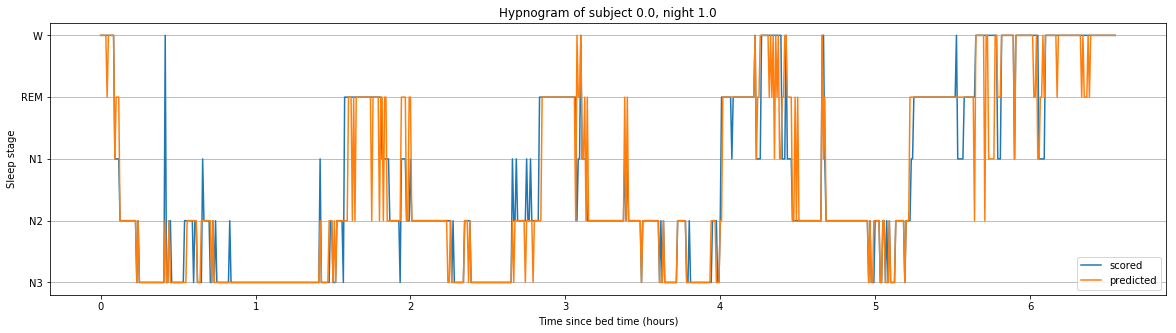

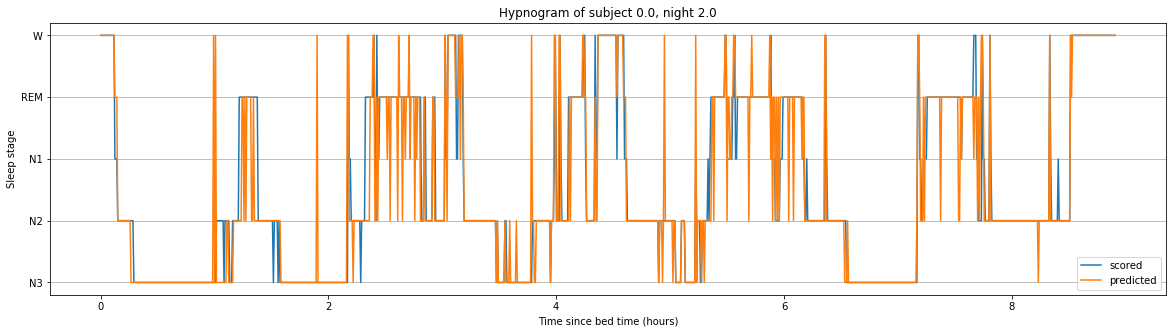

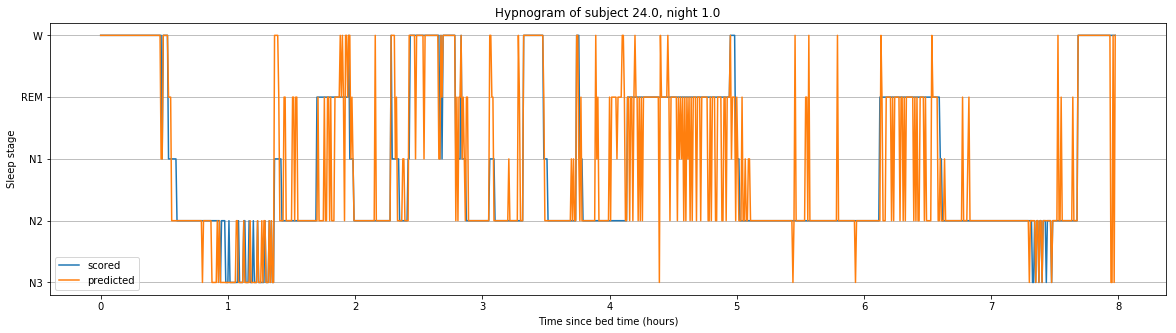

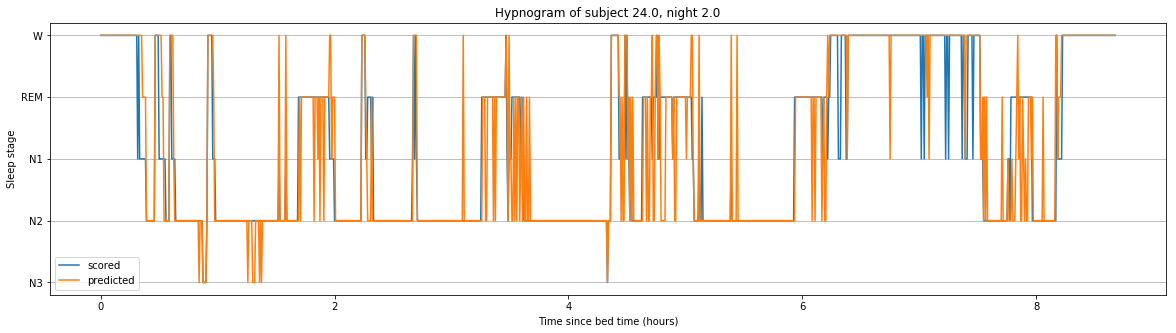

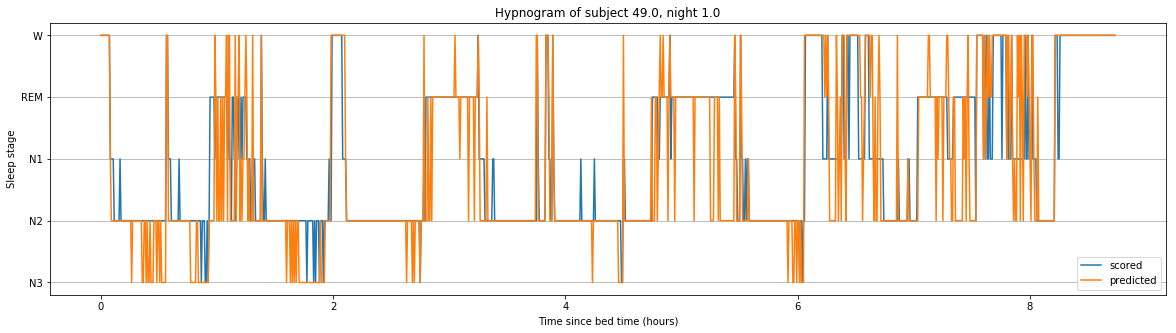

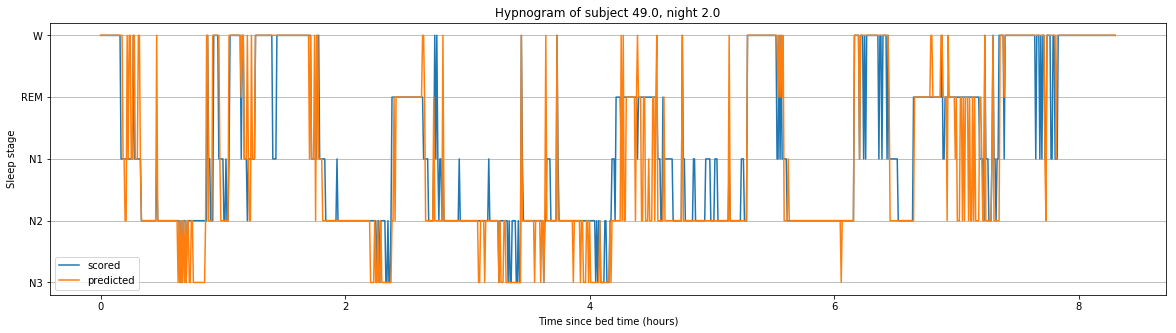

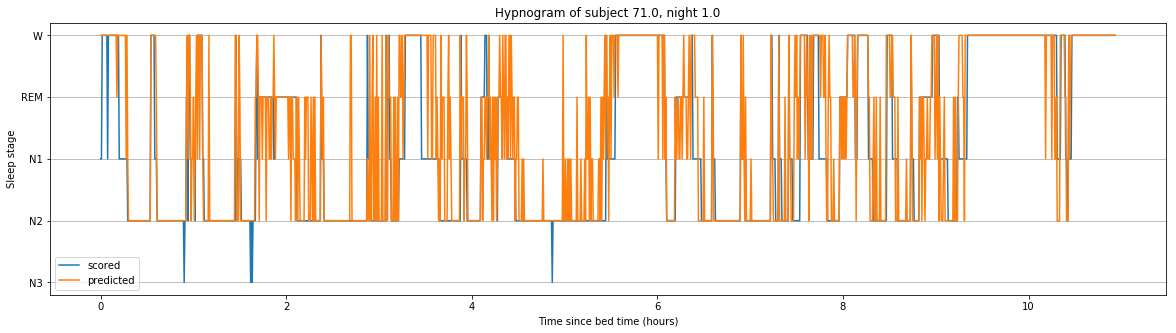

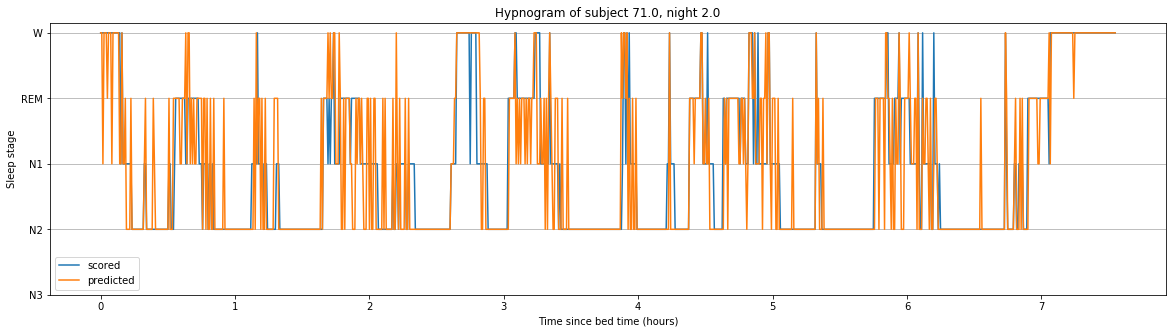

In [34]:
print("Test subjects are subjects: ", np.unique(X_test[:,0]))
print("BEFORE HMM")
plt.rcParams["figure.figsize"] = (20,5)

for test_subject in np.unique(X_test[:,0]):
    test_subject_indexes = [idx for idx, elem in enumerate(X_test) if elem[0] == test_subject]
    
    for night_idx in np.unique(X_test[test_subject_indexes,1]):
        test_night_subject_indexes = [
            idx for idx, elem in enumerate(X_test)
            if elem[0] == test_subject and elem[1] == night_idx]
        hypnograms = [
            y_test[test_night_subject_indexes],
            y_test_pred[test_night_subject_indexes]
        ]
        
        print_hypnogram(hypnograms,
                        labels=["scored", "predicted"],
                        subject=test_subject,
                        night=night_idx)

Test subjects are subjects:  [ 0. 24. 49. 71.]
AFTER HMM


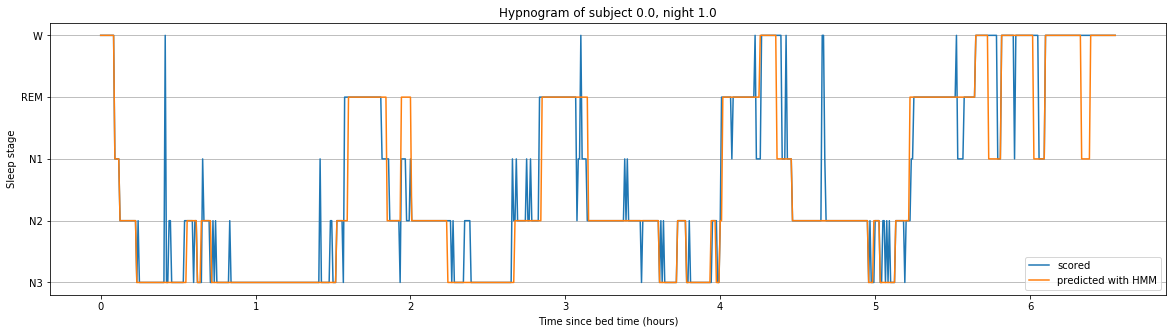

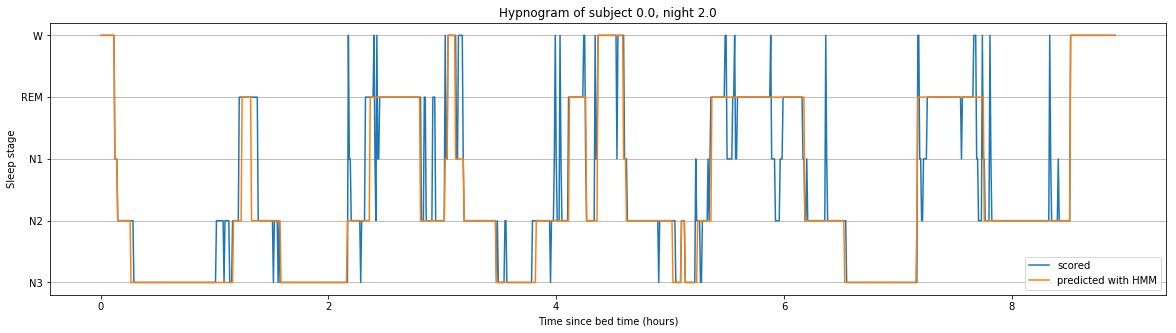

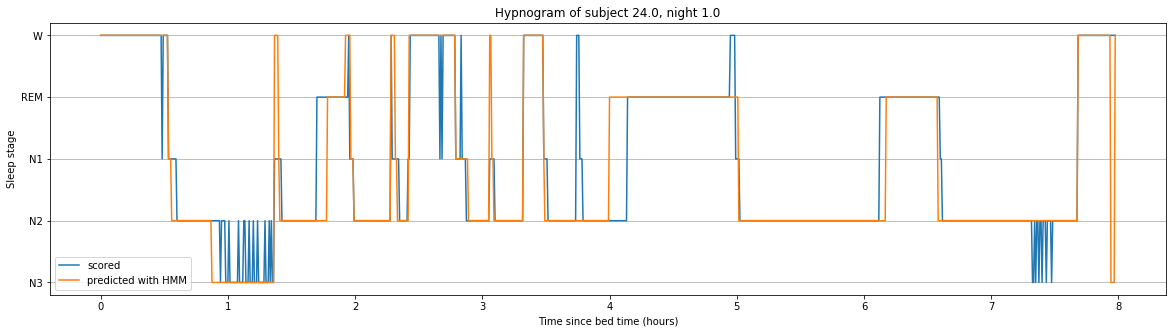

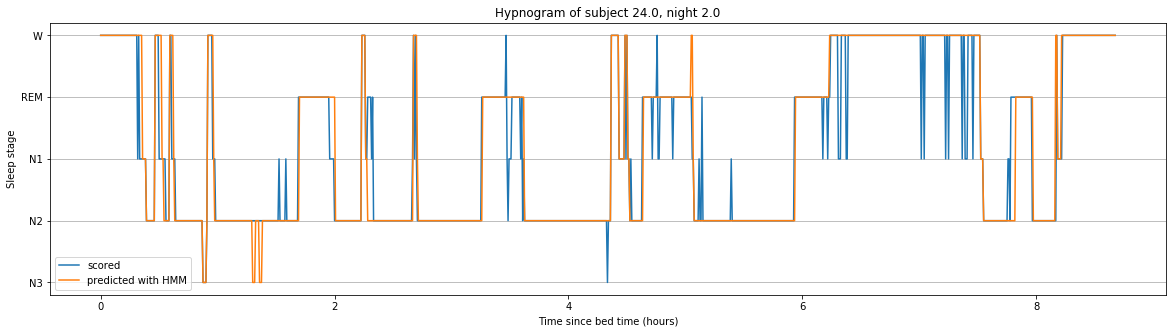

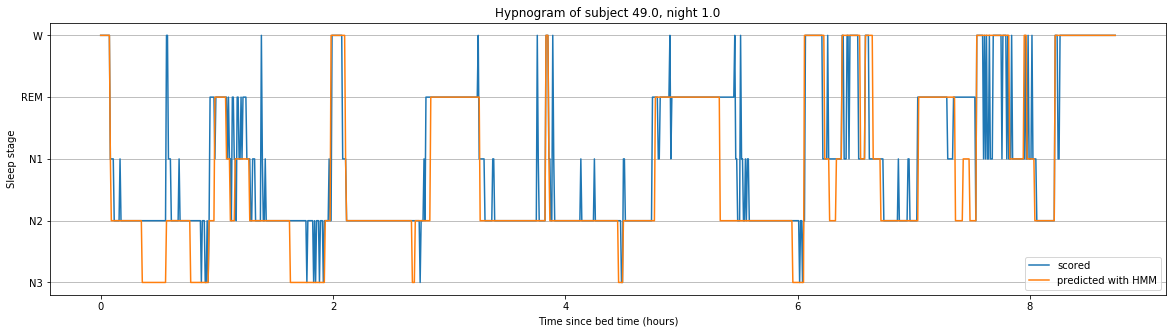

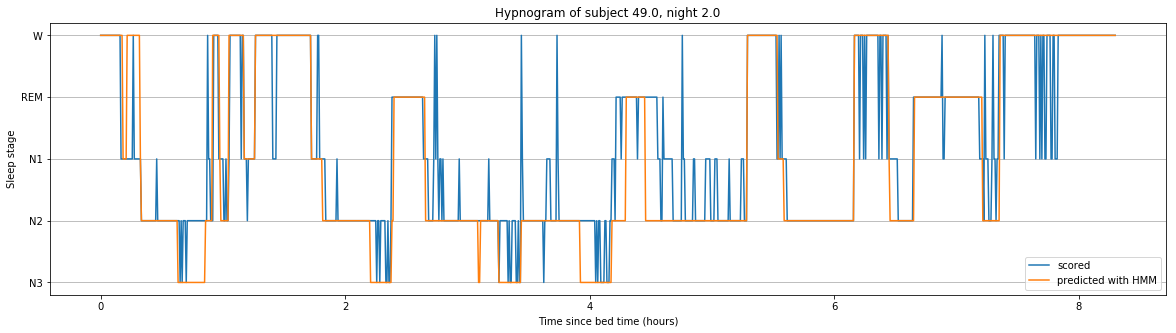

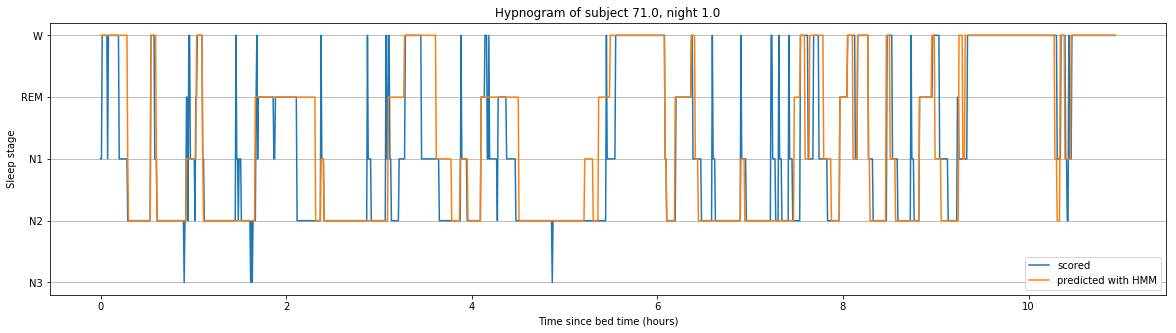

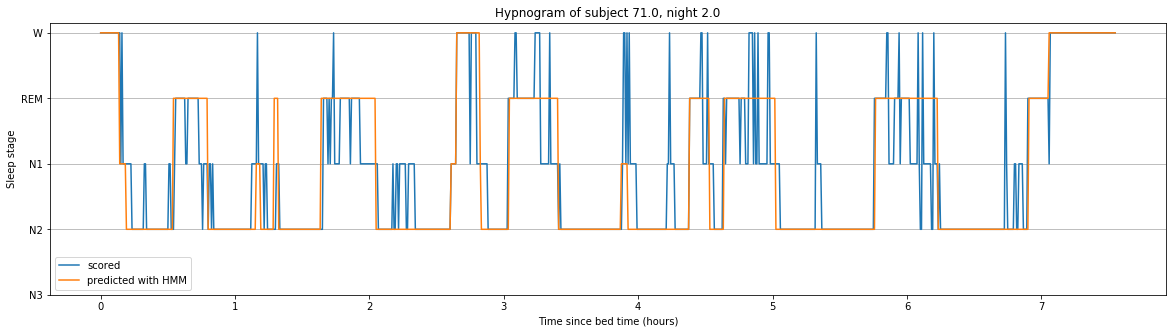

In [35]:
print("Test subjects are subjects: ", np.unique(X_test[:,0]))
print("AFTER HMM")

for test_subject in np.unique(X_test[:,0]):
    test_subject_indexes = [idx for idx, elem in enumerate(X_test) if elem[0] == test_subject]
    
    for night_idx in np.unique(X_test[test_subject_indexes,1]):
        test_night_subject_indexes = [
            idx for idx, elem in enumerate(X_test)
            if elem[0] == test_subject and elem[1] == night_idx]
        hypnograms = [
            y_test[test_night_subject_indexes],
            y_hmm_pred[test_night_subject_indexes]
        ]
        
        print_hypnogram(hypnograms,
                        labels=["scored", "predicted with HMM"],
                        subject=test_subject,
                        night=night_idx)

## Median filter
___

In order to compare the HMM postprocessing step, we will apply a median filter to the output of the RF.

We apply a median filter with a 3 element sized kernel. It is applied to each nights sleep seperatly. We do this because short transitions are not common in sleep patterns:

> The final stage includes median filtration of short-term transitions. It is well known that short-term transitions in human sleep are impossible. Short-term jumps in hypnogram are evidence of transitory stage. Averaging for 2-3 min allows the curve structure to be smoothed and sleep structure to be resolved. 

Source: Doroshenkov, L. G., V. A. Konyshev, et S. V. Selishchev. « Classification of Human Sleep Stages Based on EEG Processing Using Hidden Markov Models ». Biomedical Engineering 41, nᵒ 1 (janvier 2007): 25‑28. https://doi.org/10.1007/s10527-007-0006-5.


In [36]:
KERNEL_SIZE=3
y_medfilt_pred = np.zeros(y_test.shape[0])

for test_subject in np.unique(X_test[:,0]):
    test_subject_indexes = [idx for idx, elem in enumerate(X_test) if elem[0] == test_subject]
    
    for night_idx in np.unique(X_test[test_subject_indexes,1]):
        test_night_subject_indexes = [
            idx for idx, elem in enumerate(X_test)
            if elem[0] == test_subject and elem[1] == night_idx]

        y_medfilt_pred[test_night_subject_indexes] = medfilt(y_test_pred[test_night_subject_indexes], kernel_size=KERNEL_SIZE)

In [37]:
print(confusion_matrix(y_test, y_medfilt_pred))

print(classification_report(y_test, y_medfilt_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test, y_medfilt_pred))

[[1484   62   32    4   42]
 [ 196  154  444    3  186]
 [  18   35 3295  190   65]
 [   2    0   50  559    0]
 [  28   66  282    2  924]]
              precision    recall  f1-score   support

           W       0.86      0.91      0.89      1624
          N1       0.49      0.16      0.24       983
          N2       0.80      0.91      0.86      3603
          N3       0.74      0.91      0.82       611
         REM       0.76      0.71      0.73      1302

    accuracy                           0.79      8123
   macro avg       0.73      0.72      0.71      8123
weighted avg       0.76      0.79      0.76      8123

Agreement score (Cohen Kappa):  0.6987917422305223


Test subjects are subjects:  [ 0. 24. 49. 71.]


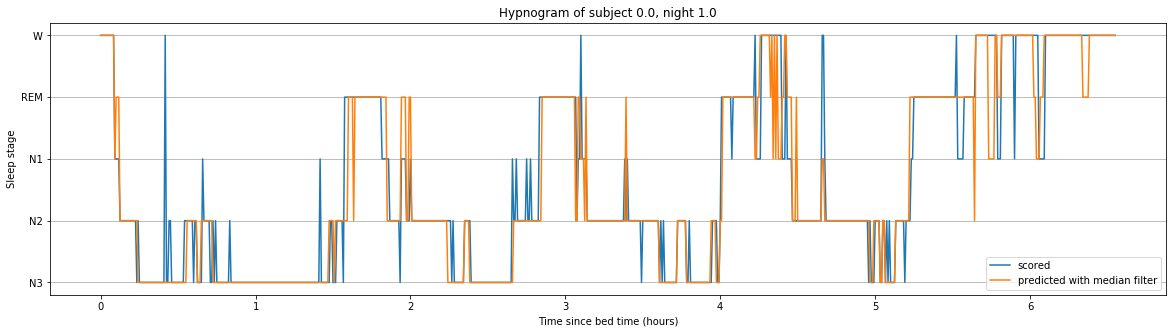

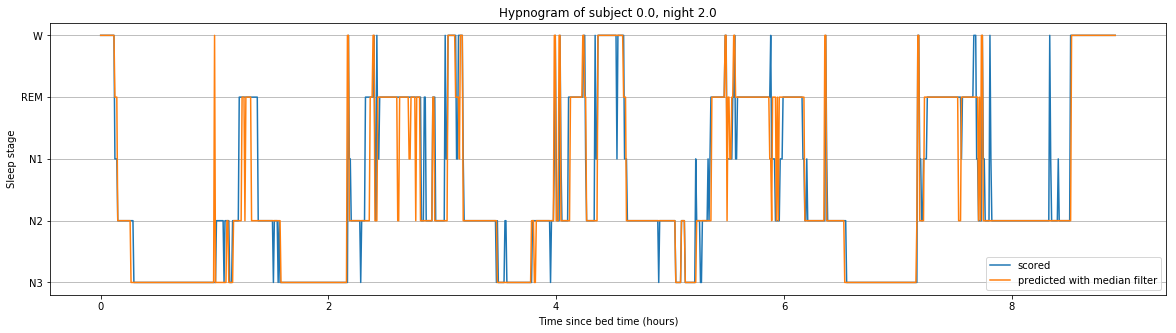

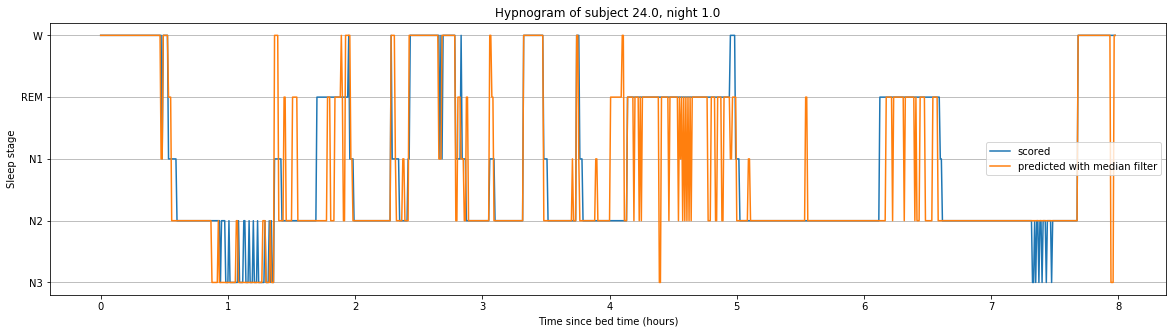

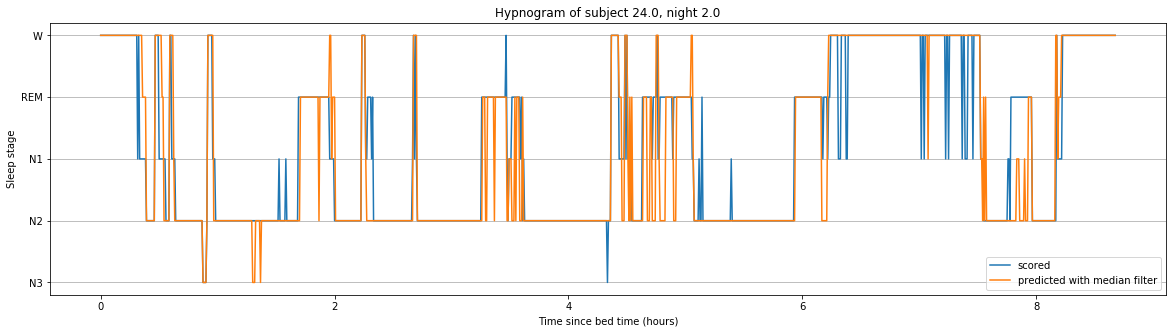

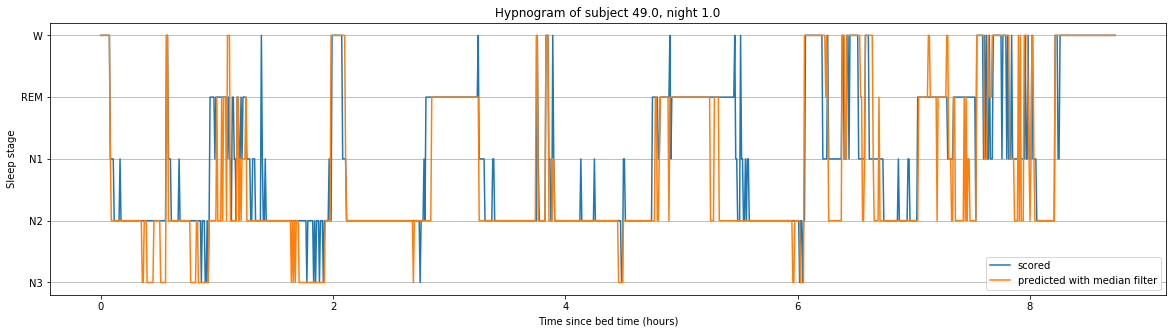

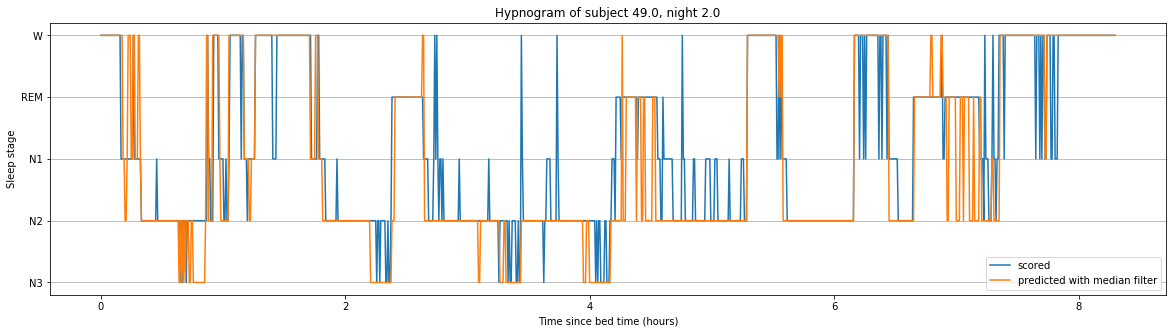

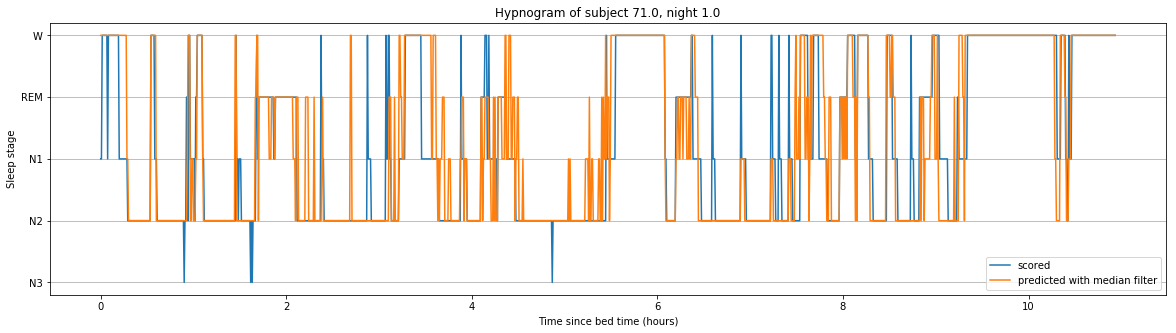

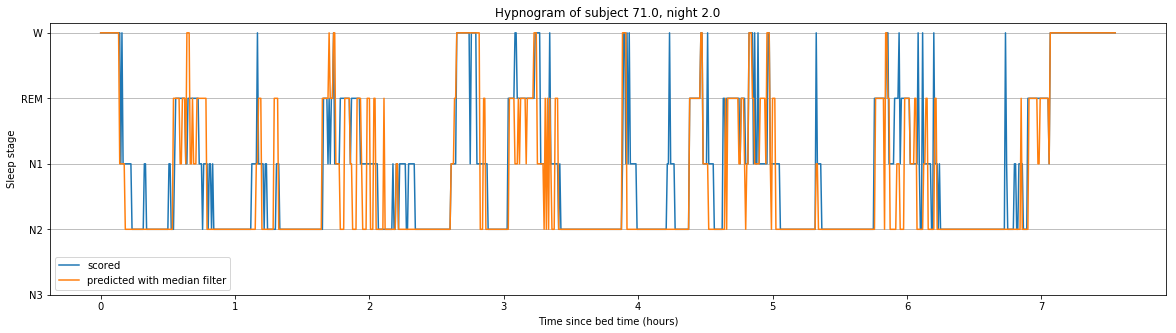

In [38]:
plt.rcParams["figure.figsize"] = (20,5)

print("Test subjects are subjects: ", np.unique(X_test[:,0]))

for test_subject in np.unique(X_test[:,0]):
    test_subject_indexes = [idx for idx, elem in enumerate(X_test) if elem[0] == test_subject]
    
    for night_idx in np.unique(X_test[test_subject_indexes,1]):
        test_night_subject_indexes = [
            idx for idx, elem in enumerate(X_test)
            if elem[0] == test_subject and elem[1] == night_idx]
        
        hypnograms = [
            y_test[test_night_subject_indexes],
            y_medfilt_pred[test_night_subject_indexes]
        ]
        
        print_hypnogram(hypnograms,
                        labels=["scored", "predicted with median filter"],
                        subject=test_subject,
                        night=night_idx)

## Saving trained model
___

We save the trained model with the postprocessing step, HMM. We will save only the matrix that define it. We do not need to persist the median filter postprocessing step, because it is stateless.

In [39]:
SAVED_DIR = "../trained_model"

if not os.path.exists(SAVED_DIR):
    os.mkdir(SAVED_DIR);    

In [40]:
if USE_CONTINUOUS_AGE: 
    joblib.dump(testing_pipeline, f"{SAVED_DIR}/classifier_RF_continous_age.joblib")
else:
    joblib.dump(testing_pipeline, f"{SAVED_DIR}/classifier_RF_TUNED_2.joblib")

In [41]:
np.save(f"{SAVED_DIR}/HMM_transmat.npy", hmm_model.transmat_)
np.save(f"{SAVED_DIR}/HMM_startprob.npy", hmm_model.startprob_)
np.save(f"{SAVED_DIR}/HMM_emissionprob.npy", hmm_model.emissionprob_)